# Needed for consistently measuring RVs.
To consistently measure the RVs of my target stars, I need to align them with the telluric lines. That is because I took no effort to make sure they are consistent by e.g. observing an RV standard or something. I have a decent amount of code already written for the IGRINS pipeline, so lets just re-use that.

## Status as of end of day Thusday, Sep 3:
  - Seems to work. Need to go through and apply to all of my stars I guess?
  - How stable is the rv fit?
  - Is it the same for all echi files that go into the final ones?
  - Need to keep track of the velocity changes to include in the companion velocities (or just re-run the ccf analysis on the new files)

In [26]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import HelperFunctions
import telfit
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import FittingUtilities
from scipy.optimize import minimize
from functools import partial
import Telluric_Wavecal
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
home = os.environ['HOME']
#sys.path.append('{}/School/Research/IGRINS_data/plp/recipes/'.format(home))
#import recipe_tell_wvsol

%matplotlib inline

In [66]:
from astropy.io import fits
reload(Telluric_Wavecal)
logger.setLevel(logging.INFO)
o2_fitter = Telluric_Wavecal.VelocityFitter('../20150113/HIP_24505.fits', tell_orders=(690, 765))
h2o_fitter = Telluric_Wavecal.VelocityFitter('../20150113/HIP_24505.fits', tell_orders=(700., 715., 725., 735.))

Warning, 1016 of 497887 bins contained negative fluxes; they have been set to zero.


In [67]:
print('O2 Fit:\n================')
o2_rv, o2_rv_err = o2_fitter.fit()
print('\n\nH2O Fit:\n===============')
h2o_rv, h2o_rv_err = h2o_fitter.fit()

O2 Fit:
[[Variables]]
    rv:     -0.13472441 +/- 0.004375 (3.25%) (init= 0)
    alpha:   0.74726715 +/- 0.001222 (0.16%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
[[Variables]]
    rv:     -0.15409304 +/- 0.004405 (2.86%) (init= 0)
    alpha:   0.73266613 +/- 0.001206 (0.16%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
[[Variables]]
    rv:     -0.14812964 +/- 0.004342 (2.93%) (init= 0)
    alpha:   0.75876287 +/- 0.001225 (0.16%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
[[Variables]]
    rv:     -0.14970099 +/- 0.004304 (2.88%) (init= 0)
    alpha:   0.76106190 +/- 0.001220 (0.16%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
[[Variables]]
    rv:     -0.14502609 +/- 0.004436 (3.06%) (init= 0)
    alpha:   0.73676336 +/- 0.001235 (0.17%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
[[Variables]]
    rv:     -0.14228957 +/- 0.004216 (2.96%) (init= 0)
    alpha:   0.75422587

<IPython.core.display.Javascript object>


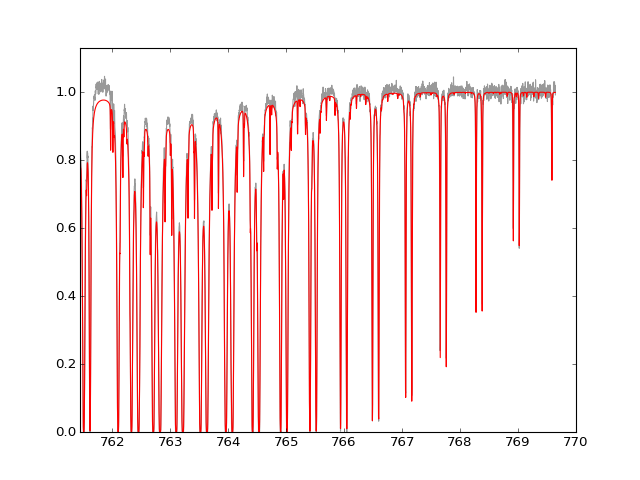

In [65]:
%matplotlib nbagg
#import matplotlib
#print matplotlib.__version__
modelfcn = partial(new_telluric, telluric, 0.74)
orders = fitter.data['echi150113.1156-0.fits']
c = Telluric_Wavecal.C_LIGHT
for order in orders:
    x = order.x*(1+rv/c)
    y = order.y / order.cont
    plt.plot(x, y, 'k-', alpha=0.4)
    plt.plot(x, modelfcn(x), 'r-', lw=1)

In [3]:
orders = HelperFunctions.ReadExtensionFits('../20150520/echi150520.1168-0.fits')

In [4]:
# Make a telluric model
modeler = telfit.Modeler()
lowfreq = 1e7/(orders[-1].x[-1]+2)
highfreq = 1e7/(orders[0].x[0]-2)
original_model = modeler.MakeModel(lowfreq=lowfreq, highfreq=highfreq)

In [5]:
# Reduce the resolution on the telluric model
new_x = np.logspace(np.log(original_model.x[0]), np.log(original_model.x[-1]), original_model.size(), base=np.e)
full_model = FittingUtilities.RebinData(original_model, new_x)
full_model = FittingUtilities.ReduceResolutionFFT(full_model, 110000)

# Interpolate the telluric model
telluric = spline(full_model.x, full_model.y)

Warning, 1156 of 2871405 bins contained negative fluxes; they have been set to zero.


In [6]:
c = 3e5
new_telluric = lambda tell, alpha, x: tell(x)**alpha
def lnlike(pars, data_orders, modelfcn):
    rv, alpha = pars
    new_modelfcn = partial(new_telluric, modelfcn, alpha)
    ll = 0.0
    for order in data_orders:
        x = order.x*(1+rv/c)
        y = order.y / order.cont
        e = order.err / order.cont
        ll += -0.5 * np.sum((y - new_modelfcn(x))**2 / e**2 + np.log(2*np.pi*(e**2)))
    print rv, alpha, ll
    return ll

def errfcn(pars, data_orders, modelfcn):
    return -lnlike(pars, data_orders, modelfcn)

0.0 0.65 43044.8775088
1e-08 0.65 43044.8771298
0.0 0.65000001 43044.8846354
-5.0 2.0 -2994711.8263
-4.99999999 2.0 -2994711.82003
-5.0 2.00000001 -2994711.83392
-0.419172910838 0.763176685926 62352.447958
-0.419172900838 0.763176685926 62352.4489755
-0.419172910838 0.763176695926 62352.4475648
-0.161913497421 0.74831585873 78158.8324106
-0.161913487421 0.74831585873 78158.8326105
-0.161913497421 0.74831586873 78158.8326868
-0.0849727220686 0.771565271364 77963.5993925
-0.0849727120686 0.771565271364 77963.5993505
-0.0849727220686 0.771565281364 77963.5984569
-0.126941113013 0.758883563464 78651.0277689
-0.126941103013 0.758883563464 78651.0278572
-0.126941113013 0.758883573464 78651.0274764
-0.0997108461197 0.753534081059 78851.960733
-0.0997108361197 0.753534081059 78851.9607337
-0.0997108461197 0.753534091059 78851.9607297
-0.0995133556808 0.753472252787 78851.9768402
-0.0995133456808 0.753472252787 78851.9768403
-0.0995133556808 0.753472262787 78851.9768402
-0.0994901092368 0.75347

<IPython.core.display.Javascript object>


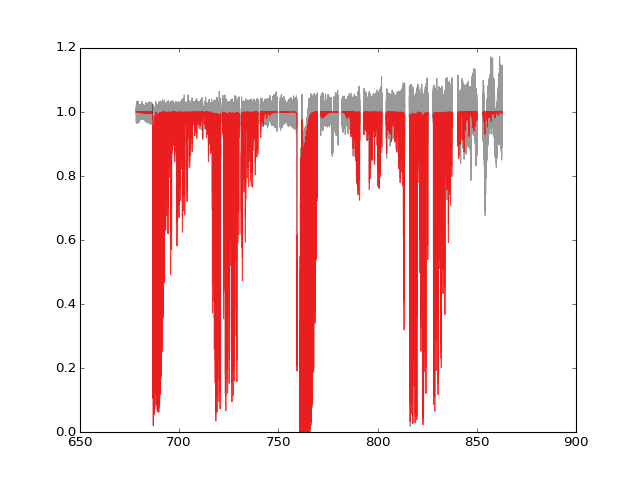

In [9]:
rv_vals = np.linspace(-2, 2, 20)
ll = np.empty_like(rv_vals)
modelfcn = partial(new_telluric, telluric, 0.65)
out = minimize(errfcn, [0.0, 0.65], args=(orders[41:], telluric), bounds=((-5, 5), (0, 2)))
rv, alpha = out.x
modelfcn = partial(new_telluric, telluric, alpha)
print('Best RV = {}\nBest alpha = {}'.format(rv, alpha))

%matplotlib nbagg
for order in orders[40:]:
    x = order.x*(1+rv/c)
    y = order.y / order.cont
    plt.plot(x, y, 'k-', alpha=0.4)
    plt.plot(x, modelfcn(x), 'r-', lw=1, alpha=0.8)
    

<IPython.core.display.Javascript object>


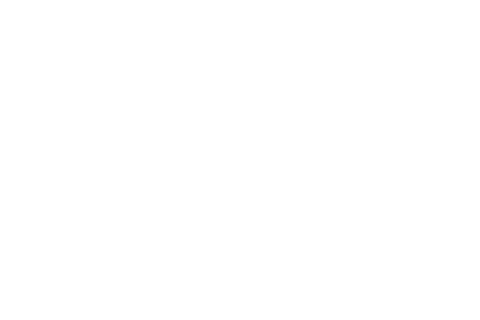

best-fit alpha = 0.618490020271
best-fit alpha = 0.999980880489
best-fit alpha = 1.0
best-fit alpha = 0.618478232672


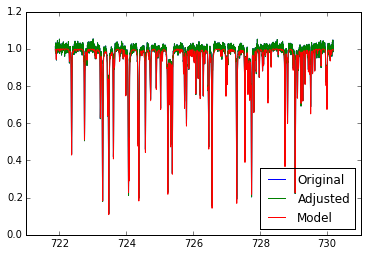

In [51]:
order = orders[45]

%matplotlib notebook
plt.plot(order.x, order.y/order.cont, label='Original')
data = np.array((order.x, order.y/order.cont))
new_data = optimize_order_wavelength(data, telluric, fitorder=2, N=3)
plt.plot(new_data[0], new_data[1], label='Adjusted')
tmp = adjust_telluric(new_data, telluric)
plt.plot(new_data[0], tmp(new_data[0]), label='Model')
plt.legend(loc='best')


best-fit alpha = -8.51412775255
best-fit alpha = 2.64408906474
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 95.1839738425
best-fit alpha = 1.06234826426
best-fit alpha = 1.00018016219
best-fit alpha = 1.00073632697
best-fit alpha = 1.00018106827
best-fit alpha = 4.96573187402
best-fit alpha = 1.00599432777
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 2.87349282588
best-fit alpha = 1.00121933894
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 12.856317211
best-fit alpha = 1.01607647724
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0129699707
best-fit alpha = 10.0770510915
best-fit alpha = 3.70417282722
best-fit alpha = 1.0
best-fit alpha = 1.00270271301
best-fit alpha = 428.411329499
best-fit alpha = 1.00728521809
best-fit alpha = 1.00102903124
best-fit alpha = 1.00062180281
best-fit alpha = 1.00001848323
best-fit alpha = 172.339973737
best-fit alpha 

<IPython.core.display.Javascript object>


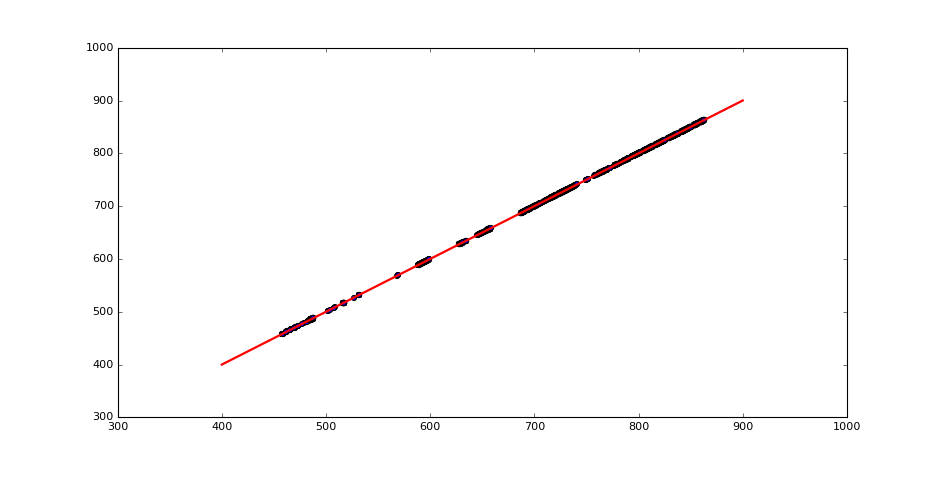

In [36]:
old_waves = []
new_waves = []
weights = []
for order in orders:
    data = np.array((order.x, order.y/order.cont))
    new_data = optimize_order_wavelength(data, telluric)
    if new_data is not None:
        lines = FittingUtilities.FindLines(order, tol=0.90)
        if len(lines) < 1:
            continue
        old_waves.append(data[0][lines])
        new_waves.append(new_data[0][lines])
        weights.append(1.0 - data[1][lines])

old_waves = np.hstack(old_waves)
new_waves = np.hstack(new_waves)
weights = np.hstack(weights)

%matplotlib notebook
plt.scatter(old_waves, new_waves)
plt.plot(plt.xlim(), plt.ylim(), 'r-', lw=2)

In [43]:
v = (old_waves - new_waves)/new_waves * 3e5
print np.mean(v), np.median(v), np.std(v)

0.503338472207 0.0459732892819 10.7078170589


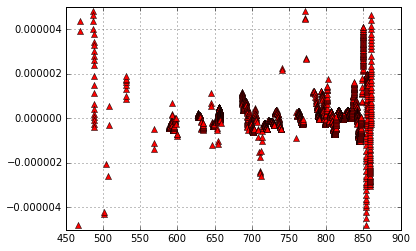

In [49]:
plt.plot(new_waves, (old_waves-new_waves)/old_waves, 'r^')
plt.ylim((-5e-6, 5e-6))
plt.grid()